# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle detection** 
***

---

---

This notebook contains the code for the P5 -> Vehicle detection.

The document is organized as follows:

    1. Definition of functions to extract features
    2. Training of classifier
    3. Prediction on single image
    4. Prediction on video

## 1. Definition of functions to extract features

In [1]:
# Import necessary libraries for the project
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import math
import collections
import operator
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Binned color

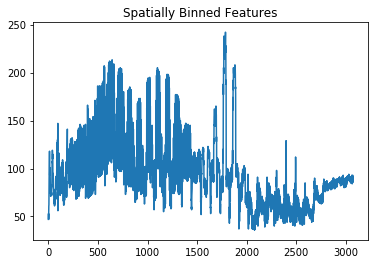

In [2]:
# Function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Read test image
image = cv2.imread('./test_images/test8.png')
# Get color features
binned = bin_spatial(image)
# Plot features
plt.plot(binned)
plt.title('Spatially Binned Features')
plt.show()

### Color histogram

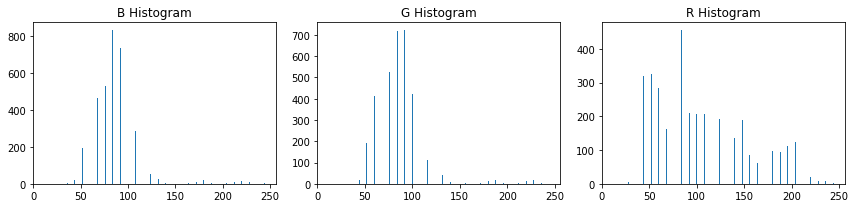

In [4]:
# Function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Redefinition for plotting results. 
def color_hist_plot(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features, channel1_hist, channel2_hist, channel3_hist, bin_centers

# Get color histogram features
hist_feat, ch1hist, ch2hist, ch3hist, bincen = color_hist_plot(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bincen, ch1hist[0])
plt.xlim(0, 256)
plt.title('B Histogram')
plt.subplot(132)
plt.bar(bincen, ch2hist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bincen, ch3hist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
fig.tight_layout()
plt.show()

### HOG

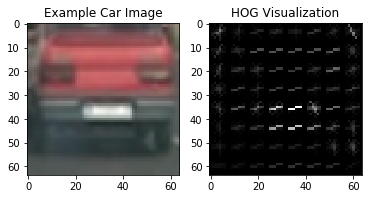

In [5]:
# Function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm='L1', transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm='L1', transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Convert to gray
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, vis=True)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

## 2. Training of classifier

### Load of image paths

In [6]:
# Extract image paths for training (GTI and KITTI)
vehicles = glob.glob('vehicles\**\*.png')
nonvehicles = glob.glob('non-vehicles\**\*.png')

# Extract image paths for testing (non-randomized data selection from GTI and KITTI)
vehicles_test = glob.glob('vehicles_test\*.png')
nonvehicles_test = glob.glob('non-vehicles_test\*.png')

# Insert extracted paths into lists
cars = []
notcars = []
cars_test = []
notcars_test = []
for image in vehicles:
    cars.append(image)
for image in nonvehicles:
    notcars.append(image)
for image in vehicles_test:
    cars_test.append(image)
for image in nonvehicles_test:
    notcars_test.append(image)

# Balance training and test data if not balanced
if len(cars) != len(notcars):
    sample_size = min(len(cars),len(notcars))
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]
    
if len(cars_test) != len(notcars_test):
    sample_size = min(len(cars_test),len(notcars_test))
    cars_test = cars_test[0:sample_size]
    notcars_test = notcars_test[0:sample_size]

# Print training and test set information
print('Number of vehicle images for training:',len(cars))
print('Number of non-vehicle images for training:',len(notcars))
print('Number of vehicle images for testing:',len(cars_test))
print('Number of non-vehicle images for testing:',len(notcars_test))

Number of vehicle images for training: 7030
Number of non-vehicle images for training: 7030
Number of vehicle images for testing: 1762
Number of non-vehicle images for testing: 1762


### Feature extraction

In [7]:
# Function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)  

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Definition of color space
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

# Definition of parameters for HOG
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

# Definition of parameters for binned color and color histogram features
spatial_size = (32, 32)
hist_bins = 32

# Flags for activating different feature extractions
spatial_feat = True
hist_feat = True
hog_feat = True

# Extract features for training and test set
t=time.time()
car_features = extract_features(cars, color_space=colorspace, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
car_test_features = extract_features(cars_test, color_space=colorspace, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_test_features = extract_features(notcars_test, color_space=colorspace, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()

# Group car and non-car features, normalize data and create label vectors for training and testing
# Training
X = np.vstack((car_features, notcar_features)).astype(np.float64)   
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Testing
X_tst = np.vstack((car_test_features, notcar_test_features)).astype(np.float64)   
X_scaler_test = StandardScaler().fit(X_tst)
scaled_X_test = X_scaler_test.transform(X_tst)
y_tst = np.hstack((np.ones(len(car_test_features)), np.zeros(len(notcar_test_features))))

# Randomize training and test sets (Outputs: X_train, y_train, X_test, y_test)
rand_state = np.random.randint(0, 100)
X_train, X_test_, y_train, y_test_ = train_test_split(scaled_X, y, test_size=0.0, random_state=rand_state)
X_train_, X_test, y_train_, y_test = train_test_split(scaled_X_test, y_tst, test_size=0.99, random_state=rand_state)

# Print information
print(round(t2-t, 2), 'Seconds to extract features...')
print('Number of training samples:', X_train.shape[0])
print('Number of testing samples:', X_test.shape[0])
print('Feature vector length:', X_train.shape[1])

88.42 Seconds to extract features...
Number of training samples: 14060
Number of testing samples: 3489
Feature vector length: 7872


### Training

In [8]:
# Use a linear SVC with C=2
svc = LinearSVC(C=math.pow(2,1))

# Perform training
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print("\n")

# Check prediction for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

4.63 Seconds to train SVC...
Test Accuracy of SVC =  0.99


My SVC predicts:  [ 0.  0.  1.  1.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  0.  1.  1.  0.  1.]
0.04161 Seconds to predict 10 labels with SVC


## 3. Prediction on single image 

### Sliding window with HOG sub-sampling and multi-scaling

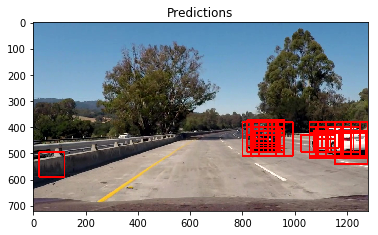

In [10]:
# Function to convert color
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

# Function that extracts features using hog sub-sampling and makes predictions
def find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bboxes = []
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255

    for scale in scales:
        
        if scale == scales[0]:
            img_tosearch = img[ystart:(ystart+((ystop-ystart)/2)),:,:]
        else:
            img_tosearch = img[ystart:ystop,:,:]
        
        ctrans_tosearch = convert_color(img_tosearch, conv='BGR2YCrCb')

        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2
        
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
        
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
    
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)
            
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, bboxes
    
# Read single image
img = cv2.imread('test_images/scene01011.jpg')

# Define start and stop on Y axis where window sliding will be applied
ystart = 350
ystop = 690
# Define scales to be applied
scales = np.array([1.0,1.5,2.0])

# Predict
out_img, bboxes = find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# Show results
plt.imshow(cv2.cvtColor(out_img,cv2.COLOR_BGR2RGB))
plt.title('Predictions')
plt.show()

### Filter false positives. Get single detection

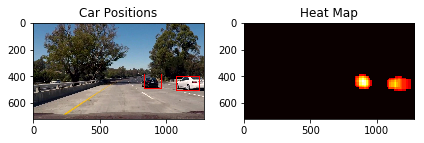

In [12]:
# Function to build heat map in function of bounding boxes
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
# Function to apply thresold on heat map
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Function to find final boxes for each label
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Read in image similar to previous one 
image = cv2.imread('test_images/scene01021.jpg')

# Define empty heat map
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,bboxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,5)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

# Draw boxes
draw_img = draw_labeled_bboxes(np.copy(image), labels)

# Plot results
fig = plt.figure()
plt.subplot(121)
plt.imshow(cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB))
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

## 4. Prediction on video

In [13]:
def pipeline(img):
    
    # Define empty heat map
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Predict on image
    out_img, bboxes = find_cars(img, pipeline.ystart, pipeline.ystop, pipeline.scales, pipeline.svc, 
                                pipeline.X_scaler, pipeline.orient, pipeline.pix_per_cell, 
                                pipeline.cell_per_block, pipeline.spatial_size, pipeline.hist_bins)
    
    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)
    
    # Add current heat map to buffer of previous heat maps
    pipeline.buffer.append(heat)
    
    # Extract mean heat map from buffer
    list_ = [pipeline.buffer[0], pipeline.buffer[1], pipeline.buffer[2], pipeline.buffer[3], pipeline.buffer[4],
                      pipeline.buffer[5], pipeline.buffer[6], pipeline.buffer[7], pipeline.buffer[8], pipeline.buffer[9],
                      pipeline.buffer[10], pipeline.buffer[11], pipeline.buffer[12], pipeline.buffer[13], pipeline.buffer[14],
                      pipeline.buffer[15], pipeline.buffer[16], pipeline.buffer[17], pipeline.buffer[18], pipeline.buffer[19],
                      pipeline.buffer[20], pipeline.buffer[21], pipeline.buffer[22], pipeline.buffer[23], pipeline.buffer[24]]
    heat = np.asarray([sum(x) for x in zip(*list_)])/pipeline.buffer_maxlength

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    # Draw boxes on image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

# Pipeline parameters
pipeline.ystart = ystart
pipeline.ystop = ystop
pipeline.scales = scales
pipeline.svc = svc
pipeline.X_scaler = X_scaler
pipeline.orient = orient
pipeline.pix_per_cell = pix_per_cell
pipeline.cell_per_block = cell_per_block
pipeline.spatial_size = spatial_size
pipeline.hist_bins = hist_bins

# Define buffer to store previous heat maps
pipeline.buffer_maxlength = 25
pipeline.buffer = collections.deque(maxlen=pipeline.buffer_maxlength)

# Initialize buffer
for i in range(pipeline.buffer_maxlength):
    pipeline.buffer.append(np.zeros_like(img[:,:,0]).astype(np.float))

# Predict on video
project_output = 'test_video_output.mp4'

clip1 = VideoFileClip('project_video.mp4')
project_clip = clip1.fl_image(pipeline)
%time project_clip.write_videofile(project_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [32:50<00:01,  1.51s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 32min 51s
